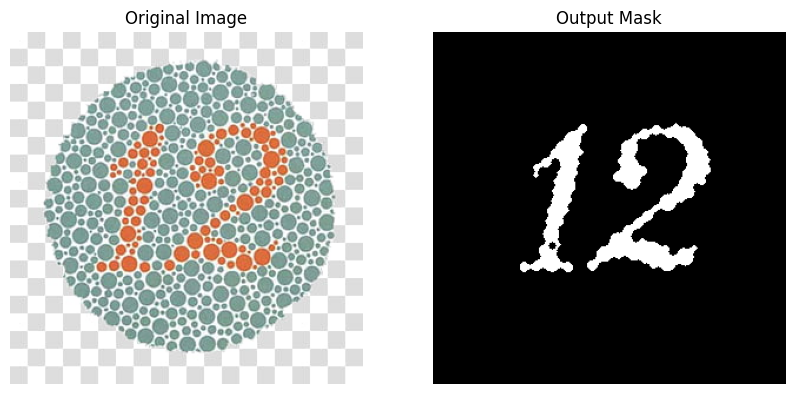

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from skimage.morphology import binary_closing, binary_opening, disk
from skimage.color import rgb2lab

class KMeans:
    def __init__(self, n_clusters=3, max_iter=300, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.centroids = None
        self.labels = None
        
    def initialize_centroids(self, X):
        # Better initialization using k-means++
        centroids = [X[np.random.choice(X.shape[0])]]
        for _ in range(1, self.n_clusters):
            distances = np.array([min([np.linalg.norm(x-c)**2 for c in centroids]) for x in X])
            probabilities = distances / distances.sum()
            cumulative_prob = probabilities.cumsum()
            r = np.random.rand()
            for j, p in enumerate(cumulative_prob):
                if r < p:
                    i = j
                    break
            centroids.append(X[i])
        return np.array(centroids)
    
    def compute_distances(self, X, centroids):
        return np.array([np.linalg.norm(X - centroid, axis=1) for centroid in centroids]).T
    
    def fit(self, X):
        self.centroids = self.initialize_centroids(X)
        
        for _ in range(self.max_iter):
            distances = self.compute_distances(X, self.centroids)
            self.labels = np.argmin(distances, axis=1)
            
            new_centroids = np.array([X[self.labels == i].mean(axis=0) 
                                    if np.sum(self.labels == i) > 0 
                                    else self.centroids[i] 
                                    for i in range(self.n_clusters)])
            
            if np.linalg.norm(new_centroids - self.centroids) < self.tol:
                break
                
            self.centroids = new_centroids
            
        return self
    
    def predict(self, X):
        distances = self.compute_distances(X, self.centroids)
        return np.argmin(distances, axis=1)

def process_ishihara_image(image_path, n_clusters=3):
    # Load and convert to LAB color space (better for color perception)
    img = np.array(Image.open(image_path))
    img_lab = rgb2lab(img)
    
    # Prepare pixel data
    h, w = img_lab.shape[:2]
    pixels = img_lab.reshape((h * w, 3))
    
    # Normalize and cluster
    scaler = MinMaxScaler()
    pixels_norm = scaler.fit_transform(pixels)
    
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(pixels_norm)
    clusters = kmeans.predict(pixels_norm).reshape((h, w))
    
    # Find the number cluster (most different from background)
    centroid_distances = np.linalg.norm(kmeans.centroids - np.mean(pixels_norm, axis=0), axis=1)
    number_cluster = np.argmax(centroid_distances)
    
    # Create and clean the mask
    mask = (clusters == number_cluster).astype(np.uint8)
    mask = binary_opening(mask, disk(2))
    mask = binary_closing(mask, disk(3))
    
    return mask * 255

def display_results(original_img, processed_img):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(processed_img, cmap='gray')
    plt.title('Output Mask')
    plt.axis('off')
    plt.show()

# Example usage
if __name__ == "__main__":
    image_path = "C:/Users/dell/Downloads/12.jpg"  # Replace with your actual image path
    try:
        original_img = Image.open(image_path)
        processed_img = process_ishihara_image(image_path, n_clusters=3)
        display_results(original_img, processed_img)
    except FileNotFoundError:
        print("Error: Image file not found. Please ensure:")
        print(f"1. The image '{image_path}' exists")
        print("2. You're running the script from the correct directory")
        print("3. The image is a valid Ishihara test (e.g., containing '74')")